# Estimate Atmospheric Parameters in a limited range of 400-900 nm
## Smooth the coefficients


Read the spectra from Pic du Midi (2019).
The spectra has been reconstructed by Spectractor.
The Spectra in fits file has been converted into panda in

https://github.com/sylvielsstfr/SpectractorAnaAtm19/blob/master/ana_20190215_HD116405_Filtre_None/ConvertSpectraToPandas.ipynb

- author Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : October 12th 2020




# Import

In [841]:
import pandas as pd
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import os,sys,re

from astropy.io import fits
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.dates as mdates
from matplotlib import gridspec
%matplotlib inline


In [842]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [843]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S

In [844]:
import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser

In [845]:
from scipy import interpolate

In [846]:
import pickle
from joblib import load

In [847]:
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model

# Functions

In [848]:
def find_nearest(a, a0):
    "Element in nd array `a` closest to the scalar value `a0`"
    idx = np.abs(a - a0).argmin()
    return a.flat[idx],int(idx)

In [849]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
        
    example:

    t=linspace(-2,2,0.1)
    x=sin(t)+randn(len(t))*0.1
    y=smooth(x)
    
    see also: 
    
    numpy.hanning, numpy.hamming, numpy.bartlett, numpy.blackman, numpy.convolve
    scipy.signal.lfilter
 
    TODO: the window parameter could be the window itself if an array instead of a string
    NOTE: length(output) != length(input), to correct this: return y[(window_len/2-1):-(window_len/2)] 
    instead of just y.
    """

    if x.ndim != 1:
        raise(ValueError, "smooth only accepts 1 dimension arrays.")

    if x.size < window_len:
        raise(ValueError, "Input vector needs to be bigger than window size.")


    if window_len<3:
        return x


    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise(ValueError, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")


    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    #print(len(s))
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    
    if len(x)%2 ==0:
        y=y[int(window_len/2-1):-int(window_len/2+1)]
    else:
        y=y[int(window_len/2-1):-int(window_len/2+1)]
    
    return y


In [850]:
def GetAtmTransparency(inputdir,filelist):
    """
    GetAtmTransparency(inputdir, filelist): retrieve atmospheric transparency from simulation

    input arguments:
     - inputdir : input directory
     - filelist : list of file to read
    """
    
    filename=filelist[0]
    full_inputfilename=os.path.join(inputdir,filename)
    hduin = fits.open(full_inputfilename)
    
    headerin=hduin[0].header
    datain=hduin[0].data
    
    hdr=headerin
    NSIMH=hdr['NBATMSIM']
    idx_num = hdr['ID_NUM']
    idx_am = hdr['ID_AM']
    idx_vaod=hdr['ID_VAOD']
    idx_pwv= hdr['ID_PWV']
    idx_o3=hdr['ID_O3']
    idx_cld=hdr['ID_CLD']
    idx_res= hdr['ID_RES']
    
    wl=datain[0,idx_res:]
    
    hduin.close() 
    
    all_data=[]
    # loop on files to extract data
    for file in filelist:
        full_inputfilename=os.path.join(inputdir,file)
        hdu = fits.open(full_inputfilename)
       
        datain=hdu[0].data
        all_data.append(datain[1:,:])
        hdu.close
        
    dataout=np.concatenate(all_data,axis=0)
    
    return wl,dataout,idx_num,idx_am,idx_vaod,idx_pwv,idx_o3,idx_cld,idx_res,headerin
        

In [851]:
def GetSpectra(inputdir,inputfiles,normalisation_factor=1):
    """
    GetSpectra(inputdir,inputfiles)
    
    input:
      - input directory
      - list of files
    
    return
      - list of dataframes
    """
    
   
    all_df = []
    idx=0
    for file in inputfiles:
        fullfilename=os.path.join(inputdir,file)
        
        df = pd.read_csv(fullfilename,index_col=0)
        spec = df["flux"].values
        specmax=spec.max()
        if specmax<1e-11:
            idx+=1
            continue
        #if idx>160 and idx<200:
        #    idx+=1
        #    continue
        
        df["flux"]=df["flux"].multiply(normalisation_factor)
        df["errflux"]=df["errflux"].multiply(normalisation_factor)
        df["mag"]=df["mag"].add(-2.5*np.log10(normalisation_factor))
        
        all_df.append(df)
        idx+=1
        
    return all_df

In [852]:
def GetSpectraFiltered(inputdir,inputfiles,normalisation_factor=1):
    """
    GetSpectraFiltered(inputdir,inputfiles)
    
    input:
      - input directory
      - list of files
    
    return
      - list of dataframes
    """
    
   
    all_df = []
    idx=0
    for file in inputfiles:
        fullfilename=os.path.join(inputdir,file)
        
        df = pd.read_csv(fullfilename,index_col=0)
        spec = df["flux"].values
        specmax=spec.max()
        if specmax<1e-11:
            idx+=1
            continue
        if idx>160 and idx<200:
            idx+=1
            continue
        if idx>220 and idx<226:
            idx+=1
            continue
        if idx>275 and idx<295:
        #if idx>260 and idx<295:
            idx+=1
            continue
            
        df["flux"]=df["flux"].multiply(normalisation_factor)
        df["errflux"]=df["errflux"].multiply(normalisation_factor)
        df["mag"]=df["mag"].add(-2.5*np.log10(normalisation_factor))
        
        all_df.append(df)
        idx+=1
        
    return all_df

In [853]:
def ConvertToImage(all_df,WLMIN=350,WLMAX=1100):
    """
    ConvertToImage(all_df,WLMIN=350,WLMAX=1100)
    
    
    """
    
    N=len(all_df)
    WL=np.arange(WLMIN,WLMAX+1)
    NWL=len(WL)
    
    mag_table=np.zeros((N,NWL))
    airm_table=np.zeros(N)
    time_table=np.zeros(N)
    
    for idx in np.arange(N):
        df=all_df[idx]
        
        fcn = interpolate.interp1d(df.wavelength,df.mag,bounds_error=False,fill_value=(0,0))
        mag_table[idx,:] = fcn(WL) 
        airm_table[idx]  = df.airmass[0]
        time_table[idx]  = df.time[0]
        
    return WL, mag_table, airm_table,time_table
       

In [854]:
def GetBouguerLinesTim(Npoints,wl,tim,magref ,FLAG_PLOT=True):
    """
    
    """
    
    WLMIN=wl.min()
    WLMAX=wl.max()
    
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    iwl_sel=[ find_nearest(wl, wl0)[1] for wl0 in wl_sel]
    NIWSEL=len(iwl_sel)
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    the_x=tim
    
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(15,8))
        ax=fig.add_subplot(111)

    for idx in np.arange(N):
        iwl=iwl_sel[idx]
        
        the_y=magref[:,iwl]
        

        if FLAG_PLOT:
            ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
    
        
    
    
    if FLAG_PLOT:
        ax.legend(loc='upper right')
        ax.set_xlim(0,the_x.max()*1.2)
        ax.grid()
        ax.set_xlabel("time (Hour)")
        ax.set_ylabel("log transmission atmosphere (mag)")
        ax.set_title("log of atmospheric transmission vs time")
        plt.show()
     
    return 
     

In [855]:
def GetBouguerLinesAtm(Npoints,wl,airmass,magref ,FLAG_PLOT=True):
    """
    
    """
    
    WLMIN=wl.min()
    WLMAX=wl.max()
    
    wl_sel=np.linspace(WLMIN,WLMAX,Npoints)
    wl_label = [ "{:3.0f} nm".format(w) for w in wl_sel]
    iwl_sel=[ find_nearest(wl, wl0)[1] for wl0 in wl_sel]
    NIWSEL=len(iwl_sel)
    
    Mags=np.zeros(NIWSEL)
    EMags=np.zeros(NIWSEL)
    
    N=NIWSEL
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    the_x=airmass
    
    
    x_fit=np.linspace(0,the_x.max(),100)
    
    if FLAG_PLOT:
        fig=plt.figure(figsize=(15,8))
        ax=fig.add_subplot(111)

    for idx in np.arange(N):
        iwl=iwl_sel[idx]
        
        the_y=magref[:,iwl]
        

        if FLAG_PLOT:
            ax.plot(the_x,the_y,'+',color=all_colors[idx],label=wl_label[idx])
    
        # fit
        popt,cov = np.polyfit(the_x, the_y, 1,cov=True)
        perr=np.sqrt(np.diag(cov))
        nstd=1
        sigmaf=np.sqrt(x_fit**2*cov[0,0]+cov[1,1]+x_fit*(cov[0,1]+cov[1,0]))
        
        Mags[idx]=popt[-1]
        EMags[idx]=sigmaf[0]
        
        p = np.poly1d(popt)
        
        y_fit=p(x_fit)
        y_fit_up=y_fit+nstd*sigmaf
        y_fit_dw=y_fit-nstd*sigmaf
        
        if FLAG_PLOT:
            ax.plot(x_fit,y_fit,'-',color=all_colors[idx])
            ax.fill_between(x_fit,y_fit_up, y_fit_dw, alpha=.25, color="gray")
    
    
    if FLAG_PLOT:
        ax.legend()
        ax.set_xlim(0,the_x.max())
        ax.grid()
        ax.set_xlabel("airmass")
        ax.set_ylabel("log transmission atmosphere (mag)")
        ax.set_title("log of atmospheric transmission vs airmass")
        plt.show()
     
    return wl_sel,Mags,EMags
     

# Constants

# Initialisation

In [856]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [857]:
# set time
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")

# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)

# timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
msg="LA time:"+  datetime_LA.strftime("%H:%M:%S")
logger.info(msg)

tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
msg="NY time:"+ datetime_NY.strftime("%H:%M:%S")
logger.info(msg)

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
msg="London time:"+ datetime_London.strftime("%H:%M:%S")
logger.info(msg)

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
msg="Paris time:"+ datetime_Paris.strftime("%H:%M:%S")
logger.info(msg)

msg="************************ START *********************"
logger.info(msg)


2020-10-13 11:26:10,207 MacBook-Pro-de-admin.local __main__[53920] INFO LA time:02:26:10
2020-10-13 11:26:10,208 MacBook-Pro-de-admin.local __main__[53920] INFO NY time:05:26:10
2020-10-13 11:26:10,209 MacBook-Pro-de-admin.local __main__[53920] INFO London time:10:26:10
2020-10-13 11:26:10,210 MacBook-Pro-de-admin.local __main__[53920] INFO Paris time:11:26:10
2020-10-13 11:26:10,211 MacBook-Pro-de-admin.local __main__[53920] INFO ************************ START *********************


In [858]:
# arguments
#----------

parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""


# Configuration

In [859]:
# config file
# --------------
configfile = "config/default.ini"
#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)


2020-10-13 11:26:10,224 MacBook-Pro-de-admin.local __main__[53920] INFO Configuration file : config/default.ini


In [860]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

2020-10-13 11:26:10,231 MacBook-Pro-de-admin.local __main__[53920] INFO 1) Configuration


In [861]:
config_section = config.sections()

In [862]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)

In [863]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(int(config['GENERAL']['FLAG_DEBUG']))
    FLAG_VERBOSE = bool(int(config['GENERAL']['FLAG_VERBOSE']))
    FLAG_PLOT   = bool(int(config['GENERAL']['FLAG_PLOT']))
    FLAG_PRINT  = bool(int(config['GENERAL']['FLAG_PRINT']))
    inputdir    = config['GENERAL']['inputdir']
    inputfile   = config['GENERAL']['inputfile']
    target      = config['GENERAL']['object']
    sedfilename = config['GENERAL']['sedfilename']
    WLMINSEL      = float(config['GENERAL']['WLMINSEL'])
    WLMAXSEL      = float(config['GENERAL']['WLMAXSEL'])
    normalisation_factor = float(config['GENERAL']['normalisation_factor'])

else:
    msg = f"Configuration file : empty section GENERAL in config file {config_filename} !"   
    logger.error(msg)
    
   
if 'ATMOSPHERE' in config_section:
    inputdir_atm  =  config['ATMOSPHERE']['inputdir_atm']
    inputfile_atm = config['ATMOSPHERE']['inputfile_atm'] 
    
    basefilename_atm=inputfile_atm.split(".")[0]  
    
    packetsize = int(config['ATMOSPHERE']['packetsize'])
    maxnbpacket = int(config['ATMOSPHERE']['maxnbpacket'])
    
else:
    msg = f"Configuration file : empty section ATMOSPHERE in config file {config_filename} !"   
    logger.error(msg)
      
    
if 'ML' in config_section:
# scaler data in ../MLfit_atm2_data

    file_scaler_wl      = config['ML']['file_scaler_wl']
    file_scaler_ymean   = config['ML']['file_scaler_ymean']
    file_scaler_yvar    = config['ML']['file_scaler_yvar']
    file_scaler_yscale  = config['ML']['file_scaler_yscale']
    file_scaler_xmean   = config['ML']['file_scaler_xmean']
    file_scaler_xvar    = config['ML']['file_scaler_xvar']
    file_scaler_xscale  = config['ML']['file_scaler_xscale']
    
    file_scaler_x       = config['ML']['file_scaler_x']
    file_scaler_y       = config['ML']['file_scaler_y']
else:
    msg = f"Configuration file : empty section ML in config file {config_filename} !"   
    logger.error(msg)

if 'SIMULATION' in config_section:

    file_specsim_order12 = config['SIMULATION']['file_specsim_order12']
    file_specsim_order2  = config['SIMULATION']['file_specsim_order2']


    file_model_linearregression       = config['SIMULATION']['file_model_linearregression']
    file_model_linearregression_ridge = config['SIMULATION']['file_model_linearregression_ridge']
    file_model_linearregression_lasso = config['SIMULATION']['file_model_linearregression_lasso']
else:
    msg = f"Configuration file : empty section SIMULATION in config file {config_filename} !"   
    logger.error(msg)

In [864]:
msg=f" Object observed {target}"
logger.info(msg)

2020-10-13 11:26:10,275 MacBook-Pro-de-admin.local __main__[53920] INFO  Object observed HD116405


In [865]:
input_file_split=inputfile.split(".")    
basefilename=input_file_split[0]
extendfilename=input_file_split[1]

# input files

## sed

In [866]:
s0=S.FileSpectrum(os.path.join(path_sed_calspec,sedfilename))

In [867]:
sed_w=s0.wave/10
sed_f=s0.flux*10
sed_idx=np.where(np.logical_and(sed_w>350,sed_w<1100))[0]
sed_w=sed_w[sed_idx]
sed_f=sed_f[sed_idx]

In [868]:
sed_m=-2.5*np.log10(sed_f)

## Atmosphere parameters for simulation

In [869]:
all_files = os.listdir(inputdir_atm)
sorted_files=sorted(all_files)

# search string
search_str="^"+f"{basefilename_atm}.*fits$"

selected_atmfiles=[]
for file in sorted_files:
    if re.search(search_str,file):
        selected_atmfiles.append(file)
        
if maxnbpacket>0:
    selected_atmfiles=selected_atmfiles[:maxnbpacket]

In [870]:
wl_atm,datain,idx_num,idx_am,idx_vaod,idx_pwv,idx_o3,idx_cld,idx_res,header=GetAtmTransparency(inputdir_atm ,selected_atmfiles)

In [871]:
NSIM=datain.shape[0]

In [872]:
num_atmsim     = datain[0:,idx_num]
airmass_atmsim = datain[0:,idx_am]
vaod_atmsim    = datain[0:,idx_vaod] # vertical aerosol depth
pwv_atmsim     = datain[0:,idx_pwv]   # precipitable water vapor (mm)
ozone_atmsim   = datain[0:,idx_o3]     # ozone
cld_atmsim     = datain[0:,idx_cld]   # clouds (not us

In [873]:
num=datain[0:,idx_num]
airmass_sim=datain[0:,idx_am]
vaod_sim=datain[0:,idx_vaod] # vertical aerosol depth
pwv_sim=datain[0:,idx_pwv]   # precipitable water vapor (mm)
ozone_sim=datain[0:,idx_o3]     # ozone
cld_sim=datain[0:,idx_cld]   # clouds (not us

In [874]:
airmassarr=airmass_sim[:,np.newaxis]
vaodarr=vaod_sim[:,np.newaxis]
pwvarr=pwv_sim[:,np.newaxis]
o3arr=ozone_sim[:,np.newaxis]
cldarr=cld_sim[:,np.newaxis]

In [875]:
Ysim=np.concatenate((vaodarr,pwvarr,o3arr,cldarr),axis=1)
Ylabel=["vaod","pwv","ozone","cld"]

## Read Simulation of Spectra

In [876]:
wl_atm=np.load(file_scaler_wl)
spec_sim=np.load(file_specsim_order12)

In [877]:
spec_sim.shape

(10000, 606)

In [878]:
wl_atm.shape

(606,)

## Smooth sim spectra

In [879]:
lw_smooth=11

In [880]:
spec_sim_smooth=np.zeros(spec_sim.shape)

In [881]:
for idx in np.arange(NSIM):
    spec_sim_smooth[idx,:]= smooth(spec_sim[idx],window_len=lw_smooth,window='hanning')  

In [882]:
spec_sim = np.copy(spec_sim_smooth)

### Apply cloud attenuation

In [883]:
spec_sim=spec_sim*np.exp(-airmassarr*cldarr)

### Selection of the airmass < 1.5

In [884]:
index_sim=np.where(airmass_sim<=1.5)[0]

### Find the maxixum

In [885]:
all_sim_max=np.zeros(NSIM)

for idx in np.arange(NSIM):
    idx_max=np.where(spec_sim[idx,:]==spec_sim[idx,:].max())[0]
    all_sim_max[idx]=spec_sim[idx,idx_max]

In [886]:
all_sim_max_sel_airmass=all_sim_max[index_sim]

In [887]:
spec_sim_max=all_sim_max_sel_airmass.max()

## data

In [888]:
inputdir_good="data_clean"
inputdir_bad="data_bad"

In [889]:
all_files_good = os.listdir(inputdir_good)
sorted_files_good=sorted(all_files_good)

In [890]:
all_files_bad = os.listdir(inputdir_bad)
sorted_files_bad=sorted(all_files_bad)

In [891]:
# search string
search_str="^"+f"{basefilename}.*csv$"

In [892]:
selected_files_good=[]
for file in sorted_files_good:
    if re.search(search_str,file):
        selected_files_good.append(file)

In [893]:
selected_files_bad=[]
for file in sorted_files_bad:
    if re.search(search_str,file):
        selected_files_bad.append(file)

In [894]:
NBFILES_GOOD=len(selected_files_good)
NBFILES_BAD=len(selected_files_bad)

In [895]:
msg=f" Number of good selected files is {NBFILES_GOOD}"
logger.info(msg)

2020-10-13 11:26:11,845 MacBook-Pro-de-admin.local __main__[53920] INFO  Number of good selected files is 276


In [896]:
msg=f" Number of bad selected files is {NBFILES_BAD}"
logger.info(msg)

2020-10-13 11:26:11,850 MacBook-Pro-de-admin.local __main__[53920] INFO  Number of bad selected files is 71


## Read all data files spectra

In [897]:
all_df_good=GetSpectra(inputdir_good,selected_files_good,normalisation_factor=normalisation_factor)
all_df_bad=GetSpectra(inputdir_bad,selected_files_bad,normalisation_factor=normalisation_factor)

In [898]:
NBFILES_GOOD=len(all_df_good)
NBFILES_BAD=len(all_df_bad)

In [899]:
msg=f" Number of good spectra is {NBFILES_GOOD}"
logger.info(msg)

2020-10-13 11:26:15,345 MacBook-Pro-de-admin.local __main__[53920] INFO  Number of good spectra is 275


In [900]:
msg=f" Number of good spectra is {NBFILES_BAD}"
logger.info(msg)

2020-10-13 11:26:15,351 MacBook-Pro-de-admin.local __main__[53920] INFO  Number of good spectra is 70


# Smooth spectra

## Find the maximum in the data

In [901]:
all_flux_max=[]
for ifile in np.arange(NBFILES_GOOD):
    the_df=all_df_good[ifile]
    the_flux=the_df.flux.values
    the_fluxmax=the_flux.max()
    all_flux_max.append(the_fluxmax)

In [902]:
all_flux_max=np.array(all_flux_max)

In [903]:
the_fluxmax_data=all_flux_max.max()

In [904]:
the_fluxmax_data

4.184461870024858e-12

# Normalisation of data relative to simulation

In [905]:
norm_datasim=spec_sim_max/the_fluxmax_data

In [906]:
norm_datasim

1.2074572066432292

In [907]:
norm_datasim=1.25

In [908]:
1/norm_datasim

0.8

(0.0, 6e-12)

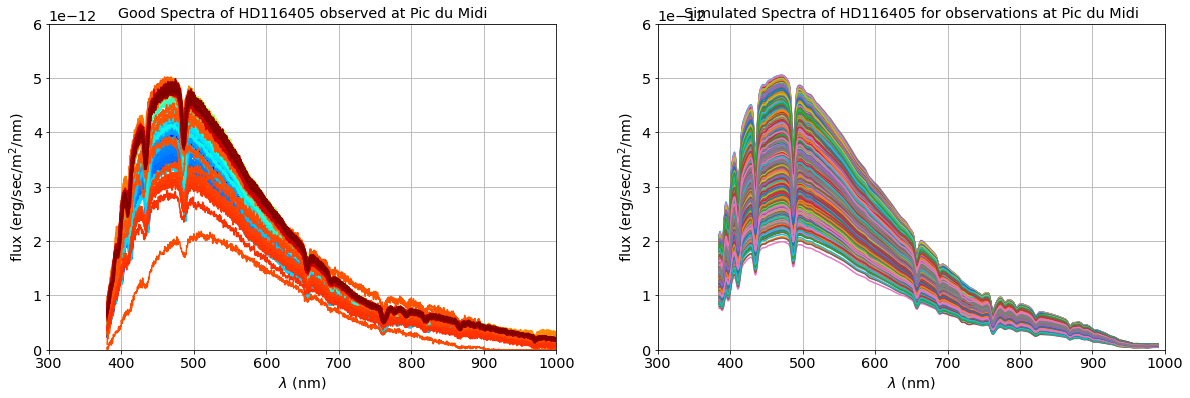

In [909]:
fig=plt.figure(figsize=(20,6))

#-----
ax=fig.add_subplot(121)
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBFILES_GOOD)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBFILES_GOOD), alpha=1)

for ifile in np.arange(NBFILES_GOOD):
    the_df=all_df_good[ifile]

    
    if ifile < 152 or ifile>202:
        #ax.plot(the_df.wavelength,the_df.flux,all_colors[ifile])
        ax.plot(the_df.wavelength,the_df.flux*norm_datasim,color=all_colors[ifile])
   
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Good Spectra of {target} observed at Pic du Midi"
ax.set_title(title)
#ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(300,1000)
ax.set_ylim(0,6e-12)

#-----
ax=fig.add_subplot(122)

jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NBFILES_BAD)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NBFILES_BAD), alpha=1)

for ifile in np.arange(NSIM):
    if airmass_sim[ifile]<1.5:
        ax.plot(wl_atm,spec_sim[ifile,:])
    #ax.errorbar(the_df.wavelength,the_df.flux,yerr=the_df.errflux, fmt = '.', color=all_colors[ifile],capsize = .01, ecolor=all_colors[ifile], elinewidth = .01)
ax.grid()
ax.set_xlabel("$\lambda$ (nm)")
ax.set_ylabel("flux (erg/sec/m$^2$/nm)")
title=f"Simulated Spectra of {target} for observations at Pic du Midi"
ax.set_title(title)
#ax.plot(sed_w,sed_f,'k-')
ax.set_xlim(300,1000)
ax.set_ylim(0,6e-12)

# Start Machine Learning

## Filter according the selected wavelength

In [910]:
wl_idxs = np.where(np.logical_and(wl_atm>=WLMINSEL,wl_atm<=WLMAXSEL))

In [911]:
wl=wl_atm[wl_idxs]

In [912]:
NWL=len(wl)

In [913]:
wl.shape

(441,)

## Prepare X and Xsim

In [914]:
FLAG_X_DOUBLE=False

In [915]:
if FLAG_X_DOUBLE:
    Xsim=np.zeros((NSIM,2*NWL))
    X=np.zeros((NBFILES_GOOD,2*NWL))
else:
    Xsim=np.zeros((NSIM,NWL))
    X=np.zeros((NBFILES_GOOD,NWL))
    
am=np.zeros(NBFILES_GOOD)
t=np.zeros(NBFILES_GOOD)

## Fill Xsim

In [916]:
for isim in np.arange(NSIM):
    x2=-2.5*np.log10(spec_sim[isim,wl_idxs])/airmass_atmsim[isim]
    x1=-2.5*np.log10(spec_sim[isim,wl_idxs])
    
    if FLAG_X_DOUBLE:
        x=np.concatenate((x1,x2),axis=1)
        Xsim[isim,:]=x 
    else:
        Xsim[isim,:]=x1 

## Select sim with airmass < 1.5

In [917]:
Xsim=Xsim[index_sim,:]

In [918]:
Ysim=Ysim[index_sim,:]

In [919]:
NSIM=Xsim.shape[0]

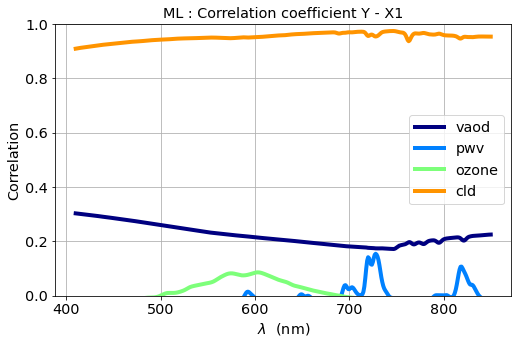

In [920]:
if FLAG_PLOT: 

    if FLAG_X_DOUBLE:
        X1=Xsim[:,:NWL]
        X2=Xsim[:,NWL:2*NWL]
    else:
        X1=Xsim
        
    Y=Ysim
    
    fig = plt.figure(figsize=(18, 5))
     
    #--------------------------------    
    ax = fig.add_subplot(121) 
    
    Ny=Y.shape[1]
    Nx=X1.shape[1]
    
    N=Ny
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    corr=np.zeros((Ny,Nx))
    
    for iy in np.arange(Ny):
        y=Y[:,iy]
        
        for ix in np.arange(Nx):
            x=X1[:,ix]
            R=np.corrcoef(x=x, y=y, rowvar=False)
            corr[iy,ix]=R[0,1]
            
        ax.plot(wl,corr[iy,:],color=all_colors[iy],label=Ylabel[iy],lw=4)
            
    ax.legend()
    ax.set_xlabel("$\lambda$  (nm)")
    ax.set_ylabel("Correlation")
    ax.set_title("ML : Correlation coefficient Y - X1")
    ax.grid()
    ax.set_ylim(0,1)    
    
    if FLAG_X_DOUBLE:
        ax = fig.add_subplot(122) 
    
        Ny=Y.shape[1]
        Nx=X2.shape[1]
    
        N=Ny
        jet = plt.get_cmap('jet')
        cNorm = colors.Normalize(vmin=0, vmax=N)
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
        all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
        corr=np.zeros((Ny,Nx))
    
        for iy in np.arange(Ny):
            y=Y[:,iy]
        
            for ix in np.arange(Nx):
                x=X2[:,ix]
                R=np.corrcoef(x=x, y=y, rowvar=False)
                corr[iy,ix]=R[0,1]
            
            ax.plot(wl,corr[iy,:],color=all_colors[iy],label=Ylabel[iy],lw=4)
            
        ax.legend()
        ax.set_xlabel("$\lambda$  (nm)")
        ax.set_ylabel("Correlation")
        ax.set_title("ML : Correlation coefficient Y - X2")
        ax.grid()
        ax.set_ylim(0,1)   
    

### Scaler for sim

In [921]:
scalersim_X = StandardScaler()
scalersim_Y = StandardScaler()

## Fill X

In [922]:
for ifile in np.arange(NBFILES_GOOD):
    the_df=all_df_good[ifile]
    
    data_airmass=the_df["airmass"][0]
    data_wl=the_df["wavelength"].values
    data_spectra=the_df["flux"].values*norm_datasim
    
    
    func=interpolate.interp1d(data_wl,data_spectra,bounds_error=False,fill_value=(0,0))
    
    data_spec_wl=func(wl)
    data_spec_smooth=smooth(data_spec_wl,window_len=lw_smooth,window='hanning')  
    
    
    if FLAG_X_DOUBLE:
        x2=-2.5*np.log10(data_spec_smooth)/data_airmass
        x1=-2.5*np.log10(data_spec_smooth)
        x=np.concatenate((x1,x2))
    else:
        x=-2.5*np.log10(func(wl))
    
    X[ifile,:]=x
    am[ifile]=data_airmass 

/Users/dagoret/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log10


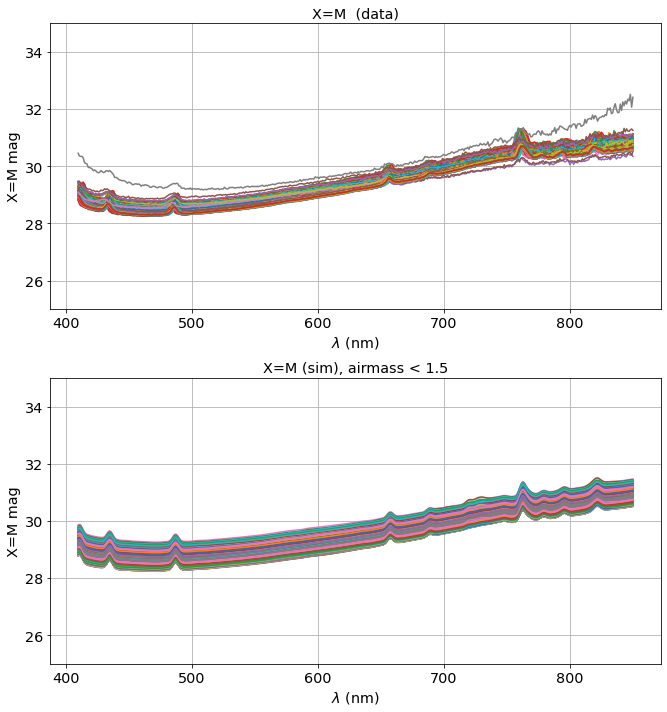

In [923]:
if FLAG_PLOT:
    N=NBFILES_GOOD
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)


    fig=plt.figure(figsize=(18,10))
    
    #.    X1. data
    ax = fig.add_subplot(221)
    for idx in np.arange(N):
        if idx <152 or idx> 202:
        #if idx <152 :
            ax.plot(wl,X[idx,:NWL])
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("X=M mag")
    ax.grid()
    ax.set_title("X=M  (data)")
    ax.set_ylim(25,35)
    
    # X2 data
    if FLAG_X_DOUBLE:
        ax = fig.add_subplot(222)
        for idx in np.arange(N):
            if idx <152 or idx> 202:
            #if idx <152 :
                ax.plot(wl,X[idx,NWL:2*NWL])
        ax.set_xlabel("$\lambda$ (nm)")
        ax.set_ylabel("X=M/z mag")
        ax.grid()
        ax.set_title("X=M/Z  (data)")
        ax.set_ylim(15,35)
    
    
    
    # X1 sim 
    ax = fig.add_subplot(223)
    for idx in np.arange(NSIM):
        
        ax.plot(wl,Xsim[idx,:NWL])
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("X=M mag")
    ax.grid()
    ax.set_title("X=M (sim), airmass < 1.5")

    ax.set_ylim(25,35)
    
    # X2 sim
    if FLAG_X_DOUBLE:
        ax = fig.add_subplot(224)
        for idx in np.arange(NSIM):
        
            ax.plot(wl,Xsim[idx,NWL:2*NWL])
        ax.set_xlabel("$\lambda$ (nm)")
        ax.set_ylabel("X=M/z mag")
        ax.grid()
        ax.set_title("X=M/Z (sim), airmass < 1.5")

        ax.set_ylim(15,35)
    
    
    plt.tight_layout()
    

# Fine correction of the throughput on magnitudes

In [924]:
FLAG_CORRECTMAG=True

In [925]:
if FLAG_CORRECTMAG:
    filecorr1 ="throughputdata/finecorrectionthrouput_magdatadivsim1.csv"
    filecorr2 ="throughputdata/finecorrectionthrouput_magdatadivsim2.csv"
    df_corr1=pd.read_csv(filecorr1,header=2,index_col=False)
    df_corr2=pd.read_csv(filecorr2,header=2,index_col=False)
    
    print(df_corr1.head())
    print(df_corr2.head())

        wl  ratiodatasim
0  385.992       1.01840
1  390.999       1.01530
2  395.998       1.01117
3  403.872       1.00716
4  410.315       1.00406
        wl  ratiodatasim
0  387.414      1.003840
1  391.694      1.000340
2  395.974      0.996837
3  404.562      0.993672
4  408.844      0.990507


In [926]:
if FLAG_CORRECTMAG:
    # do the interpolation
    fcn1 = interpolate.interp1d(df_corr1["wl"],df_corr1["ratiodatasim"],bounds_error=False,fill_value=(0,0))
    fcn2 = interpolate.interp1d(df_corr2["wl"],df_corr2["ratiodatasim"],bounds_error=False,fill_value=(0,0))
    
    corr1=fcn1(wl)
    corr2=fcn2(wl)

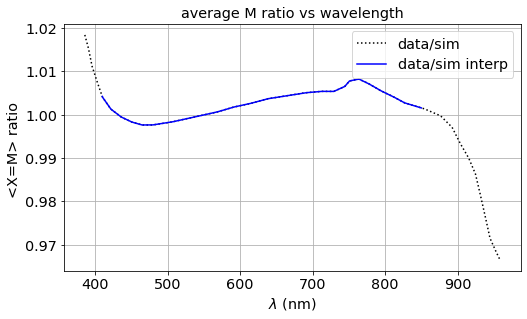

In [927]:
if FLAG_CORRECTMAG and FLAG_PLOT:
    fig=plt.figure(figsize=(18,10))
    
    ax=fig.add_subplot(221)
    ax.plot(df_corr1["wl"],df_corr1["ratiodatasim"],"k:",label="data/sim")
    ax.plot(wl,corr1,"b-",label="data/sim interp")
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("<X=M> ratio ")
    ax.grid()
    ax.legend()
    ax.set_title("average M ratio vs wavelength")
    
    
    if FLAG_X_DOUBLE:
        ax=fig.add_subplot(222)
        ax.plot(df_corr2["wl"],df_corr2["ratiodatasim"],"k:",label="data/sim")
        ax.plot(wl,corr2,"b-",label="data/sim interp")
        ax.set_xlabel("$\lambda$ (nm)")
        ax.set_ylabel("<X=M/z> ratio ")
        ax.grid()
        ax.legend()
        ax.set_title("average M/z ratio vs wavelength")
    

# Selection of simulation

### Check the slope of M, M/z vs wavelength for data and simulation

In [928]:
# select data in good range
Xdataav = np.average(X[:152,:],axis=0)
Xsimav=np.average(Xsim,axis=0)

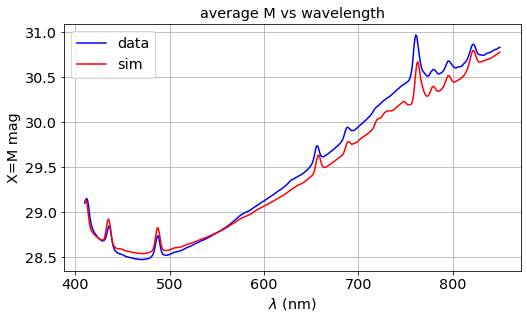

In [929]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(18,10))
    
    ax=fig.add_subplot(221)
    ax.plot(wl,Xdataav[:NWL],"b-",label="data")
    ax.plot(wl,Xsimav[:NWL],"r-",label="sim")
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("X=M mag")
    ax.grid()
    ax.legend()
    ax.set_title("average M vs wavelength")
    
    if FLAG_X_DOUBLE:
        ax=fig.add_subplot(222)
        ax.plot(wl,Xdataav[NWL:2*NWL],"b-",label="data")
        ax.plot(wl,Xsimav[NWL:2*NWL],"r-",label="sim")
        ax.set_xlabel("$\lambda$ (nm)")
        ax.set_ylabel("X=M/z mag")
        ax.grid()
        ax.legend()
        ax.set_title("average M/z vs wavelength")
    
   

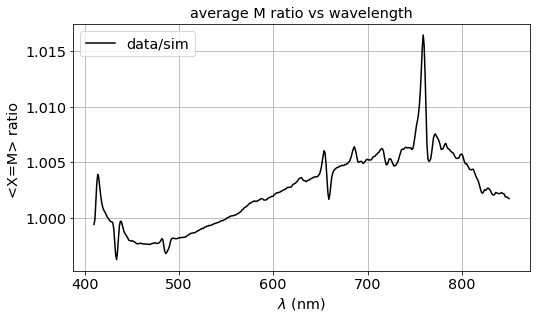

In [930]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(18,10))
    
    ax=fig.add_subplot(221)
    ax.plot(wl,Xdataav[:NWL]/Xsimav[:NWL],"k-",label="data/sim")
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("<X=M> ratio ")
    ax.grid()
    ax.legend()
    ax.set_title("average M ratio vs wavelength")
    
    if FLAG_X_DOUBLE:
        ax=fig.add_subplot(222)
        ax.plot(wl,Xdataav[NWL:2*NWL]/Xsimav[NWL:2*NWL],"k-",label="data/sim")
        ax.set_xlabel("$\lambda$ (nm)")
        ax.set_ylabel("<X=M/z> ratio ")
        ax.grid()
        ax.legend()
        ax.set_title("average M/z ratio vs wavelength")

In [931]:
FLAG_CORRECTMAG=True

In [932]:
if FLAG_CORRECTMAG:
    filecorr1 ="throughputdata/finecorrectionthrouput_magdatadivsim1.csv"
    filecorr2 ="throughputdata/finecorrectionthrouput_magdatadivsim2.csv"
    df_corr1=pd.read_csv(filecorr1,header=2,index_col=False)
    df_corr2=pd.read_csv(filecorr2,header=2,index_col=False)
    
    print(df_corr1.head())
    print(df_corr2.head())

        wl  ratiodatasim
0  385.992       1.01840
1  390.999       1.01530
2  395.998       1.01117
3  403.872       1.00716
4  410.315       1.00406
        wl  ratiodatasim
0  387.414      1.003840
1  391.694      1.000340
2  395.974      0.996837
3  404.562      0.993672
4  408.844      0.990507


In [933]:
if FLAG_CORRECTMAG:
    # do the interpolation
    fcn1 = interpolate.interp1d(df_corr1["wl"],df_corr1["ratiodatasim"],bounds_error=False,fill_value=(0,0))
    fcn2 = interpolate.interp1d(df_corr2["wl"],df_corr2["ratiodatasim"],bounds_error=False,fill_value=(0,0))
    
    corr1=fcn1(wl)
    corr2=fcn2(wl)

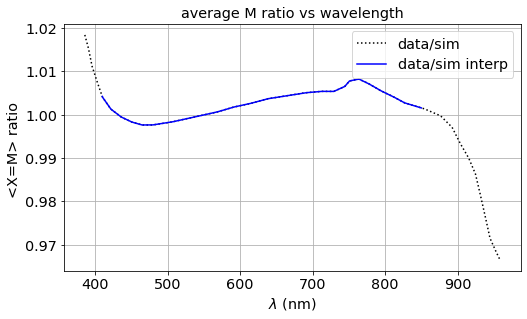

In [934]:
if FLAG_CORRECTMAG and FLAG_PLOT:
    fig=plt.figure(figsize=(18,10))
    
    ax=fig.add_subplot(221)
    ax.plot(df_corr1["wl"],df_corr1["ratiodatasim"],"k:",label="data/sim")
    ax.plot(wl,corr1,"b-",label="data/sim interp")
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("<X=M> ratio ")
    ax.grid()
    ax.legend()
    ax.set_title("average M ratio vs wavelength")
    
    if FLAG_X_DOUBLE:
        ax=fig.add_subplot(222)
        ax.plot(df_corr2["wl"],df_corr2["ratiodatasim"],"k:",label="data/sim")
        ax.plot(wl,corr2,"b-",label="data/sim interp")
        ax.set_xlabel("$\lambda$ (nm)")
        ax.set_ylabel("<X=M/z> ratio ")
        ax.grid()
        ax.legend()
        ax.set_title("average M/z ratio vs wavelength")
    

In [935]:
X.shape

(275, 441)

In [936]:
if FLAG_CORRECTMAG:
    for idx in np.arange(NBFILES_GOOD):
        X[idx,:NWL]=X[idx,:NWL]/corr1
        if FLAG_X_DOUBLE:
            X[idx,NWL:2*NWL]=X[idx,NWL:2*NWL]/corr2

2020-10-13 11:26:28,116 MacBook-Pro-de-admin.local matplotlib.legend[53920] WARNING No handles with labels found to put in legend.


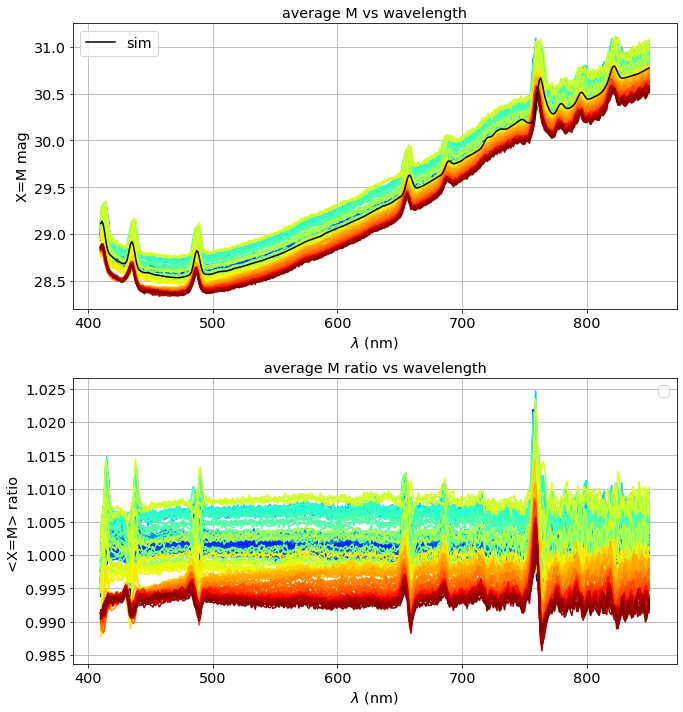

In [937]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(18,10))
    
    #-------------
    ax=fig.add_subplot(221)
    N=152
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=N)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
    
    for idx in np.arange(N):
        ax.plot(wl,X[idx,:NWL],"-",color=all_colors[idx])
        
    ax.plot(wl,Xsimav[:NWL],"k-",label="sim")
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("X=M mag")
    ax.grid()
    ax.legend()
    ax.set_title("average M vs wavelength")
    
    #---------------------------
    if FLAG_X_DOUBLE:
        ax=fig.add_subplot(222)
        N=152
        jet = plt.get_cmap('jet')
        cNorm = colors.Normalize(vmin=0, vmax=N)
        scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
        all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)
    
        for idx in np.arange(N):
            ax.plot(wl,X[idx,NWL:2*NWL],"-",color=all_colors[idx])
        
        ax.plot(wl,Xsimav[NWL:2*NWL],"k-",label="sim")
        ax.set_xlabel("$\lambda$ (nm)")
        ax.set_ylabel("X=M/z mag")
        ax.grid()
        ax.legend()
        ax.set_title("average M/z vs wavelength")
    
    #--------------------------------
    ax=fig.add_subplot(223)
    for idx in np.arange(N):
        ax.plot(wl,X[idx,:NWL]/Xsimav[:NWL],"-",color=all_colors[idx])
        
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("<X=M> ratio ")
    ax.grid()
    ax.legend()
    ax.set_title("average M ratio vs wavelength")
    
    
    #-------------------------------------
    if FLAG_X_DOUBLE:
        ax=fig.add_subplot(224)
        for idx in np.arange(N):
            ax.plot(wl,X[idx,NWL:2*NWL]/Xsimav[NWL:2*NWL],"-",color=all_colors[idx])
        
        ax.set_xlabel("$\lambda$ (nm)")
        ax.set_ylabel("<X=M/z> ratio ")
        ax.grid()
        ax.legend()
        ax.set_title("average M/z ratio vs wavelength")
    
    
    plt.tight_layout()

# Scaling from selected sim data

In [938]:
from sklearn.model_selection import train_test_split
Xsim_train, Xsim_test, Ysim_train, Ysim_test = train_test_split(Xsim, Ysim, test_size=0.4, random_state=42)

### Rescale with selected sim 

In [939]:
scalersim_X.fit(Xsim_train) 
scalersim_Y.fit(Ysim_train) 

StandardScaler()

In [940]:

X_scale=np.zeros(X.shape)
for idx in np.arange(X.shape[0]):
    if idx<152 or idx>203:
        X_scale[idx,:]=scalersim_X.transform([X[idx,:]])[0]
                      
            
Xsim_train_scale=scalersim_X.transform(Xsim_train)
Ysim_train_scale=scalersim_Y.transform(Ysim_train)
Xsim_test_scale=scalersim_X.transform(Xsim_test)
Ysim_test_scale=scalersim_Y.transform(Ysim_test)
    
NSIM_train=Xsim_train_scale.shape[0]
NSIM_test=Xsim_test_scale.shape[0]

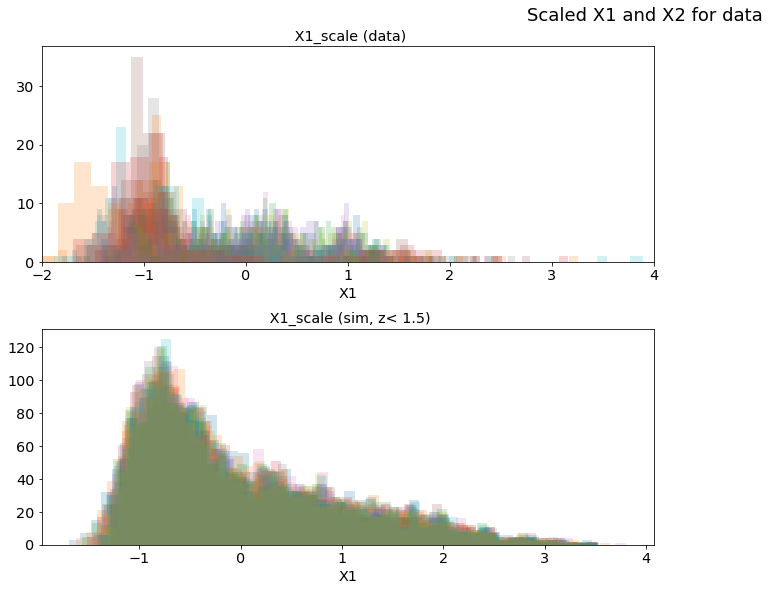

In [941]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(18,8))
    ax = fig.add_subplot(221)
    for iwl in np.arange(0,NWL,20):
        ax.hist(X_scale[:152,iwl],bins=50,alpha=0.2)
        ax.hist(X_scale[203:,iwl],bins=50,alpha=0.2)
    ax.set_title(" X1_scale (data)")
    ax.set_xlim(-2.,4)
    ax.set_xlabel("X1")
    
    if FLAG_X_DOUBLE:
        ax = fig.add_subplot(222)
        for iwl in np.arange(0,NWL,20):
            ax.hist(X_scale[:152,NWL+iwl],bins=50,alpha=0.2)
            ax.hist(X_scale[203:,NWL+iwl],bins=50,alpha=0.2)
        ax.set_title(" X2_scale (data)")
        ax.set_xlim(0,4)
        ax.set_xlabel("X2")
    
    ax = fig.add_subplot(223)
    for iwl in np.arange(0,NWL,20):
        ax.hist(Xsim_train_scale[:,iwl],bins=50,alpha=0.2)
    ax.set_title(" X1_scale (sim, z< 1.5)")
    #ax.set_xlim(0,4)
    ax.set_xlabel("X1")
    
    if FLAG_X_DOUBLE:
        ax = fig.add_subplot(224)
        for iwl in np.arange(0,NWL,20):
            ax.hist(Xsim_train_scale[:,NWL+iwl],bins=50,alpha=0.2)
        ax.set_title(" X2_scale (sim, z< 1.5)")
        #ax.set_xlim(0,4)
        ax.set_xlabel("X2")
    
    plt.suptitle("Scaled X1 and X2 for data",Y=1.02,fontsize=18)
    plt.tight_layout()

# Selected simulation

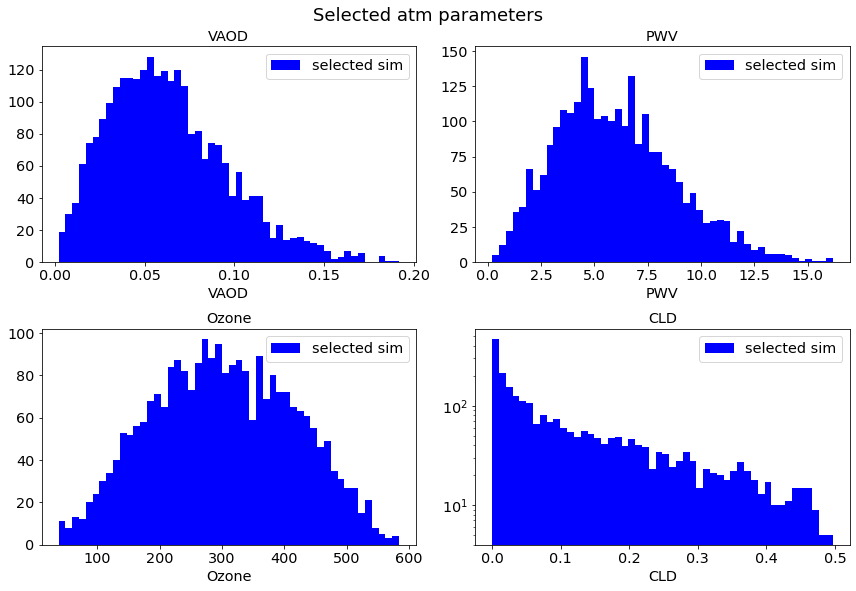

In [942]:

if FLAG_PLOT:
    fig=plt.figure(figsize=(12,8))
       
    ax = fig.add_subplot(221)
    #ax.hist(Ysim[:,0],bins=50,facecolor="grey",label="full sim")
    ax.hist(Ysim[:,0],bins=50,facecolor="b",label="selected sim")
    ax.set_title("VAOD")
    ax.set_xlabel("VAOD")
    ax.legend()
    
    
    ax = fig.add_subplot(222)
    #ax.hist(Ysim[:,1],bins=50,facecolor="grey",label="full sim")
    ax.hist(Ysim[:,1],bins=50,facecolor="b",label="selected sim")  
    ax.set_title("PWV")
    ax.set_xlabel("PWV")
    ax.legend()
       
        
    ax = fig.add_subplot(223)
    #ax.hist(Ysim[:,2],bins=50,facecolor="grey",label="full sim")
    ax.hist(Ysim[:,2],bins=50,facecolor="b",label="selected sim")
    ax.set_title("Ozone")
    ax.set_xlabel("Ozone")
    ax.legend()
    
    
    ax = fig.add_subplot(224)
    #ax.hist(Ysim[:,3],bins=50,facecolor="grey",label="full sim")
    ax.hist(Ysim[:,3],bins=50,facecolor="b",label="selected sim")  
    ax.set_title("CLD")
    ax.set_xlabel("CLD")
    ax.set_yscale("log")
    ax.legend()
    
    plt.suptitle("Selected atm parameters",Y=1.02,fontsize=18)
    plt.tight_layout()

# Nan

In [943]:
np.argwhere(np.isnan(X_scale))

array([], shape=(0, 2), dtype=int64)

# Prediction Data and Sim

## Make the model from selected sims 

In [944]:
alpha_ridge=1e-3
ridge = linear_model.Ridge(alpha=alpha_ridge, fit_intercept=True)

In [945]:
ridge.fit(Xsim_train_scale,Ysim_train_scale)

Ridge(alpha=0.001)

In [946]:
ridge.coef_

array([[ 1.05671378,  0.91695316,  0.77654107, ..., -4.44480619,
        -4.59056734, -4.70404261],
       [ 0.36281337,  0.32421446,  0.28600923, ...,  3.72751083,
         3.78299076,  3.78748705],
       [-0.348799  , -0.32175827, -0.29371044, ...,  1.64681054,
         1.89981527,  2.2991778 ],
       [-0.21026301, -0.18457663, -0.15912341, ...,  0.55734152,
         0.56382861,  0.55030453]])

In [947]:
lenw=1
ridge.coef_[0]=smooth(ridge.coef_[0],window_len=lenw,window='hanning')
ridge.coef_[1]=smooth(ridge.coef_[1],window_len=lenw,window='hanning')
ridge.coef_[2]=smooth(ridge.coef_[2],window_len=lenw,window='hanning')
ridge.coef_[3]=smooth(ridge.coef_[3],window_len=lenw,window='hanning')

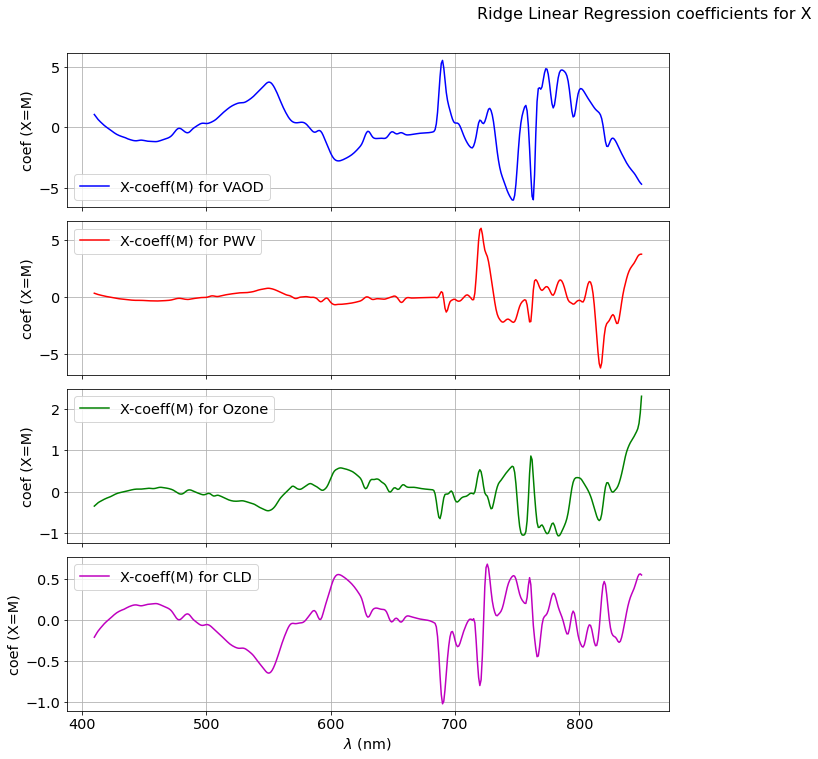

In [948]:
if FLAG_PLOT: 
    fig=plt.figure(figsize=(18,10))

    ax1 = fig.add_subplot(421)
    ax1.plot(wl,ridge.coef_[0][0:NWL],'b-',label="X-coeff(M) for VAOD")        
    #ax.set_xlabel("$\lambda$ (nm)")
    ax1.set_ylabel("coef (X=M)")
    ax1.grid()
    ax1.legend()

    
    if FLAG_X_DOUBLE:
        ax2 = fig.add_subplot(422)
        ax2.plot(wl,ridge.coef_[0][NWL:2*NWL],'b-',label="X-coeff(M/z) for VAOD")

        #ax.set_xlabel("$\lambda$ (nm)")
        ax2.set_ylabel("coef (X=M/z)")
        ax2.grid()
        ax2.legend()


    ax3 = fig.add_subplot(423)
    ax3.plot(wl,ridge.coef_[1][0:NWL],'r-',label="X-coeff(M) for PWV")        
    #ax.set_xlabel("$\lambda$ (nm)")
    ax3.set_ylabel("coef (X=M)")
    ax3.grid()
    ax3.legend()

    
    if FLAG_X_DOUBLE:
        ax4 = fig.add_subplot(424)
        ax4.plot(wl,ridge.coef_[1][NWL:2*NWL],'r-',label="X-coeff(M/z) for PWV")

        #ax.set_xlabel("$\lambda$ (nm)")
        ax4.set_ylabel("coef (X=M/z)")
        ax4.grid()
        ax4.legend()


    ax5 = fig.add_subplot(425)
    ax5.plot(wl,ridge.coef_[2][0:NWL],'g-',label="X-coeff(M) for Ozone")        
    #ax5.set_xlabel("$\lambda$ (nm)")
    ax5.set_ylabel("coef (X=M)")
    ax5.grid()
    ax5.legend()

    if FLAG_X_DOUBLE:
        ax6 = fig.add_subplot(426)
        ax6.plot(wl,ridge.coef_[2][NWL:2*NWL],'g-',label="X-coeff(M/z) for Ozone")

        #ax6.set_xlabel("$\lambda$ (nm)")
        ax6.set_ylabel("coef (X=M/z)")
        ax6.grid()
        ax6.legend()

    ax7 = fig.add_subplot(427)
    ax7.plot(wl,ridge.coef_[3][0:NWL],'m-',label="X-coeff(M) for CLD")        
    ax7.set_xlabel("$\lambda$ (nm)")
    ax7.set_ylabel("coef (X=M)")
    ax7.grid()
    ax7.legend()

    if FLAG_X_DOUBLE:
        ax8 = fig.add_subplot(428)
        ax8.plot(wl,ridge.coef_[3][NWL:2*NWL],'m-',label="X-coeff(M/z) for CLD")

        ax8.set_xlabel("$\lambda$ (nm)")
        ax8.set_ylabel("coef (X=M/z)")
        ax8.grid()
        ax8.legend()
    
    
    ax1.get_shared_x_axes().join(ax1, ax3,ax5,ax7)
    ax1.set_xticklabels([])
    ax3.set_xticklabels([])
    ax5.set_xticklabels([])
    
    if FLAG_X_DOUBLE:
        ax2.get_shared_x_axes().join(ax2, ax4,ax6,ax8)
        ax2.set_xticklabels([])
        ax4.set_xticklabels([])
        ax6.set_xticklabels([])

    plt.tight_layout()
    plt.suptitle("Ridge Linear Regression coefficients for X",Y=1.05,fontsize=16)

In [949]:
#Y_pred_scale=linearregression_model.predict([X_scale[0,:]])
Y_test_scale_pred=ridge.predict([Xsim_test_scale[0,:]])

In [950]:
NPARAM=len(Y_test_scale_pred[0])

In [951]:
all_Y_scale_data_pred=np.zeros((NBFILES_GOOD,NPARAM))

In [952]:
FLAG_DATA = np.full(NBFILES_GOOD, True)
FLAG_DATA[152:202]=False

## Predict Y_scale from X_scale in data

In [953]:
for idx in np.arange(NBFILES_GOOD):
    if not FLAG_DATA[idx] :
        continue
    y=ridge.predict([X_scale[idx,:]])[0]
    all_Y_scale_data_pred[idx,:]=y

In [954]:
# remove bad rows for data
all_Y_scale_data_pred_selected=np.delete(all_Y_scale_data_pred,np.arange(152,202),axis=0)

## Predict Y_scale from X_scale in simulation

In [955]:
all_Y_scale_train_sim_pred=ridge.predict(Xsim_train_scale)
all_Y_scale_test_sim_pred=ridge.predict(Xsim_test_scale)

# Inverse transform of scaler

In [956]:
Ydata_rec=scalersim_Y.inverse_transform(all_Y_scale_data_pred_selected)

In [957]:
Ysim_test_rec=scalersim_Y.inverse_transform(all_Y_scale_test_sim_pred)
Ysim_train_rec=scalersim_Y.inverse_transform(all_Y_scale_train_sim_pred)

# Plot

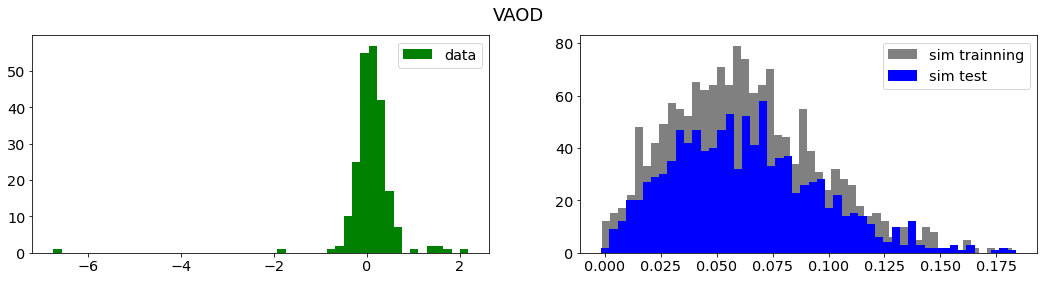

In [958]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(18,4))
    ax1 = fig.add_subplot(121)
    ax1.hist(Ydata_rec[:,0],bins=50,label="data",facecolor="green");
    ax1.legend()
    
    ax2 = fig.add_subplot(122)
    
    ax2.hist(Ysim_train_rec[:,0],bins=50,facecolor="grey",label="sim trainning");
    ax2.hist(Ysim_test_rec[:,0],bins=50,facecolor="blue",label="sim test");
    ax2.legend()
    
    plt.suptitle("VAOD",fontsize=18)

2020-10-13 11:26:40,640 MacBook-Pro-de-admin.local matplotlib.legend[53920] WARNING No handles with labels found to put in legend.


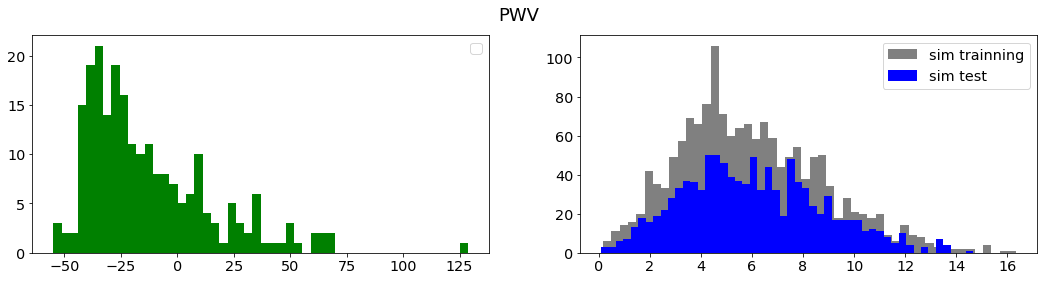

In [959]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(18,4))
    ax1 = fig.add_subplot(121)
    ax1.hist(Ydata_rec[:,1],bins=50,facecolor="green");
    ax1.legend()
    
    ax2 = fig.add_subplot(122)
    
    ax2.hist(Ysim_train_rec[:,1],bins=50,facecolor="grey",label="sim trainning");
    ax2.hist(Ysim_test_rec[:,1],bins=50,facecolor="blue",label="sim test");
    plt.suptitle("PWV",fontsize=18)
    ax2.legend()

2020-10-13 11:26:41,280 MacBook-Pro-de-admin.local matplotlib.legend[53920] WARNING No handles with labels found to put in legend.


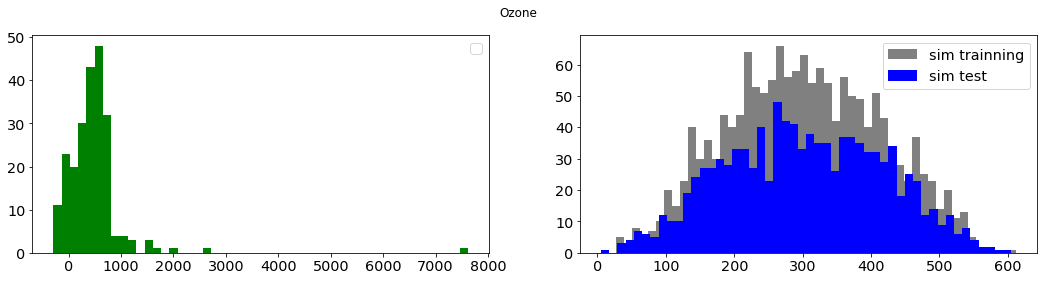

In [960]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(18,4))
    ax1 = fig.add_subplot(121)
    ax1.hist(Ydata_rec[:,2],bins=50,facecolor="green");
    ax1.legend()
    
    ax2 = fig.add_subplot(122)
    
    ax2.hist(Ysim_train_rec[:,2],bins=50,facecolor="grey",label="sim trainning");
    ax2.hist(Ysim_test_rec[:,2],bins=50,facecolor="blue",label="sim test");
    ax2.legend()
    
    plt.suptitle("Ozone")

2020-10-13 11:26:41,932 MacBook-Pro-de-admin.local matplotlib.legend[53920] WARNING No handles with labels found to put in legend.


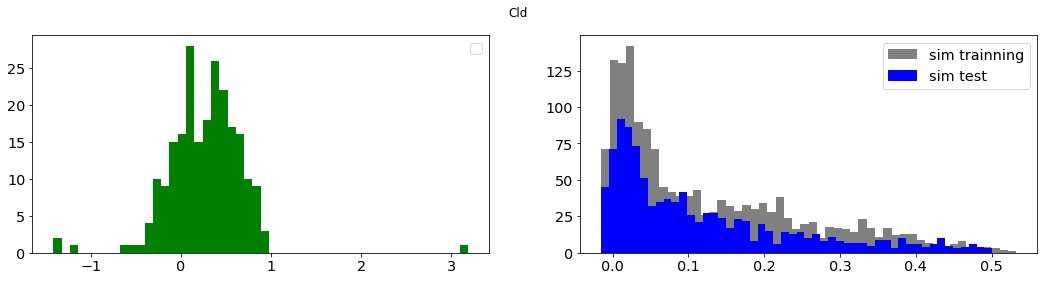

In [961]:
if FLAG_PLOT:
    fig=plt.figure(figsize=(18,4))
    ax1 = fig.add_subplot(121)
    ax1.hist(Ydata_rec[:,3],bins=50,facecolor="green");
    ax1.legend()
        
    ax2 = fig.add_subplot(122)
    
    
    
    ax2.hist(Ysim_train_rec[:,3],bins=50,facecolor="grey",label="sim trainning");
    ax2.hist(Ysim_test_rec[:,3],bins=50,facecolor="blue",label="sim test");
    ax2.legend()
    
    plt.suptitle("Cld")
     